## EDA and Feature Engineering

* In this file we will draw insight from the data, engineer the given features and create a table ready for modeling.

In [85]:
import numpy as np
import pandas as pd
import yfinance as yf #for stock data
from IPython.display import display #for displaying the full dataframes
import matplotlib.pyplot as plt #for data visualization
import seaborn as sns #for advanced data visualization
import datetime 
from sklearn import preprocessing #for ML models and data processing
import itertools  #advanced tools for loops
import math #for mathematical tools


%matplotlib inline

In [86]:
dt = pd.read_excel (r'data_clean.xlsx')

#separate train\test
train_count = round(len(dt)*0.8)
train = dt.sample(train_count)
test = pd.concat([dt, train, train]).drop_duplicates(keep=False)



### 1) Outcome:

Add dummy variables for the eda and modeling.

In [87]:

#change the WiNNER, BE, and LOSER features to dummy variables
train['is_winner'] = train['Outcome'].apply(lambda x: 1 if x=='WINNER' else 0 )
train['is_be'] = train['Outcome'].apply(lambda x: 1 if x=='BE' else 0 )
train['is_loser'] = train['Outcome'].apply(lambda x: 1 if x=='LOSER' else 0 )

### 2) Entry Price (Intended Entry):

Is there a favourable price?

Note that I am using Intended Entry because 'Entry Price' is the excecution price, meaning it may 

be affected by price volatility and high spreads, whereas 'Intended Entry' is simply the planned entry price and

is not influenced by any of those.

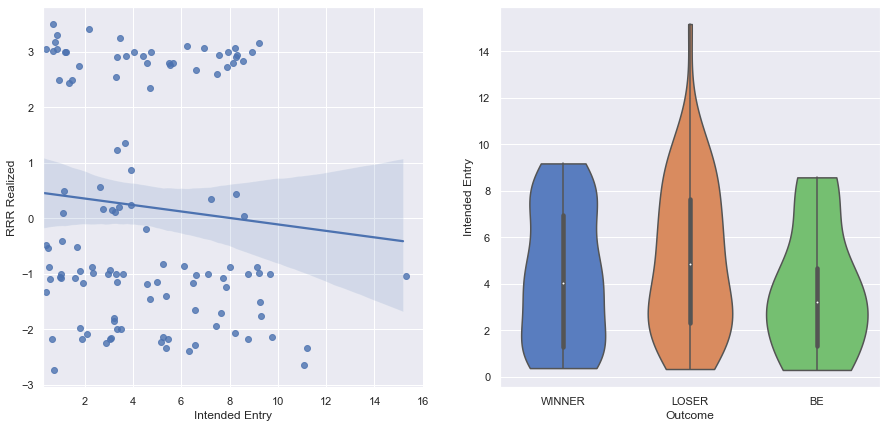

In [88]:
train1 = train[['Intended Entry','Outcome', 'RRR Realized']]
test1 = test[['Intended Entry','Outcome', 'RRR Realized']]

fig,ax = plt.subplots(1,2 ,figsize = (15,7))


ax[0] = sns.regplot(x="Intended Entry", y="RRR Realized", data=train1,ax = ax[0],x_jitter=.2)

ax[1] = sns.violinplot(x="Outcome", y="Intended Entry",data=train1, palette="muted",cut = 0,ax = ax[1])





##### Inference:
* Trades with stocks above \\$10 and under \\$0.5 tend to be less favourable.


* Trades  within the ranges: \\$0.5-\\$5 and \\$7-\\$9 potentially have the best outcome.


* The left plot shows a negative correlation, although there is high variance and low bias.


therefore I decided to group the price data to 4 groups: 0-0.5, 0.5-6,6-10,10-

Another things to note that there aren't many observations around the unfavourable values.

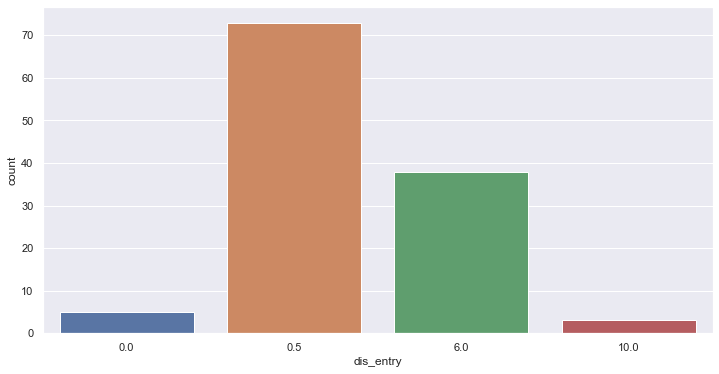

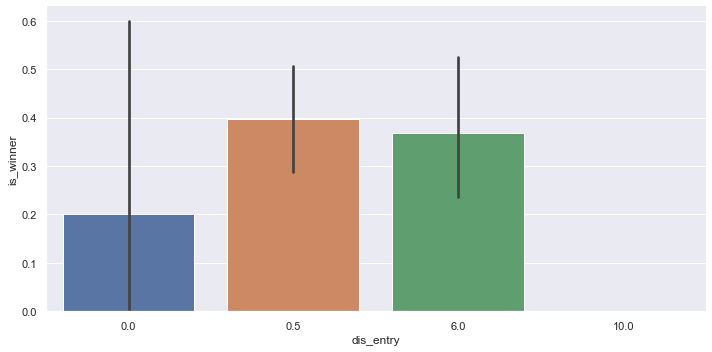

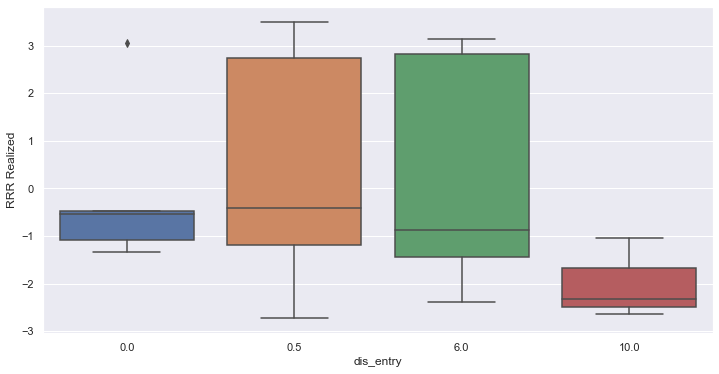

In [89]:
def replaceEntry(price):
    if price<0.5:
        price = 0
    elif price<6:
        price = 0.5
    elif price<10:
        price = 6
    else:
        price = 10
    return price

# create a new column with the discretized intended entry prices
train['dis_entry'] = train1['Intended Entry'].apply(replaceEntry)
        
test['dis_entry'] = test1['Intended Entry'].apply(replaceEntry)     
 
#plot with the new features
#plot 1

f,axes=plt.subplots(figsize=(12,6))
g = sns.countplot(x="dis_entry",data=train)



#plot 2
g= sns.catplot(x="dis_entry",y="is_winner",data=train,kind="bar", height = 5,aspect = 2)
g= g2.set_ylabels("Winning Probability")

      
#plot 3
f,axes=plt.subplots(figsize=(12,6))
g = sns.boxplot(x="dis_entry", y="RRR Realized", data=train)

### 3) Sector:

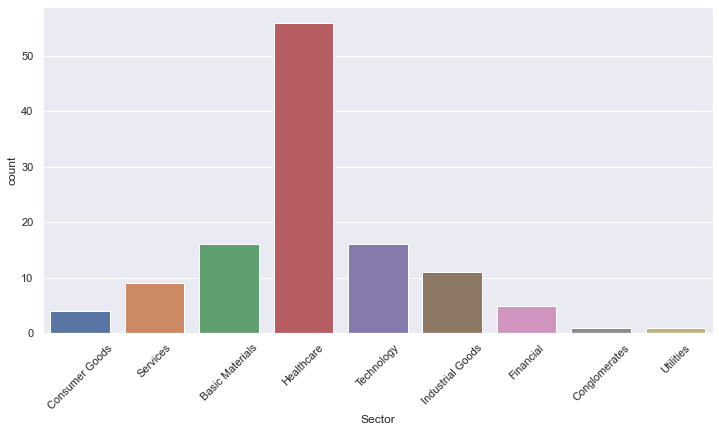

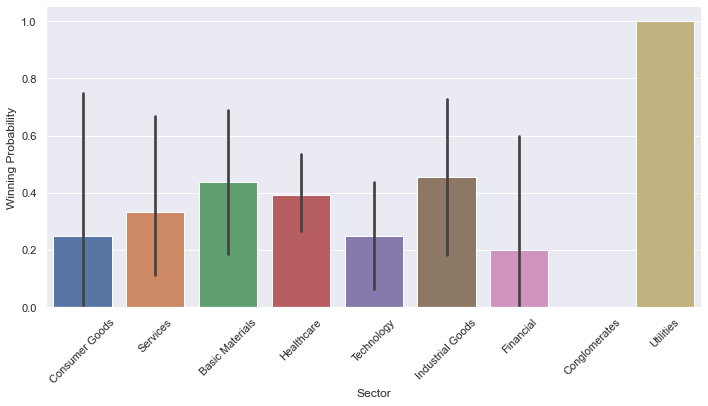

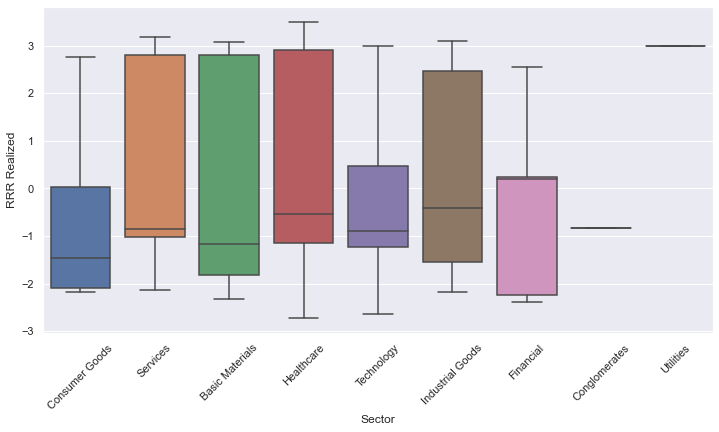

In [90]:


sns.set(style="darkgrid")

#plot 1
f,axes=plt.subplots(figsize=(12,6))
g1 = sns.countplot(x="Sector",data=train)
g1 = plt.setp(g1.get_xticklabels(), rotation=45)


#plot 2
g2= sns.catplot(x="Sector",y="is_winner",data=train,kind="bar", height = 5,aspect = 2)
g2 = g2.set_ylabels("Winning Probability")
g2.set_xticklabels(rotation=45)


#plot 3
f,axes=plt.subplots(figsize=(12,6))
g3 = sns.boxplot(x="Sector", y="RRR Realized", data=train)
g3 = plt.setp(g3.get_xticklabels(), rotation=45)





#### Inference:

Since the count of each sector excluding 'Healthcare' is low, (under 20) we see a high obvious variance within the winning probability and 'RRR Realized'. Unfortunately with such results it is difficult to determine whether there is an affect on the trades outcome.

### 4) Pattern:


The 'Pattern' abbreveations represent the technichal pattern which appeared prior to the breakout and trade entry.
I would like to see if there's perhaps a favourable pattern. Recap:

ST = symmetrical triangle

R = rectangle

DT = descending triangle

AT = ascending triangle

P = pennant

F = flag



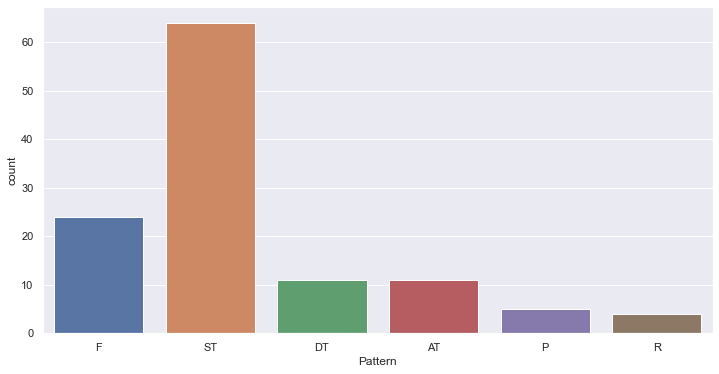

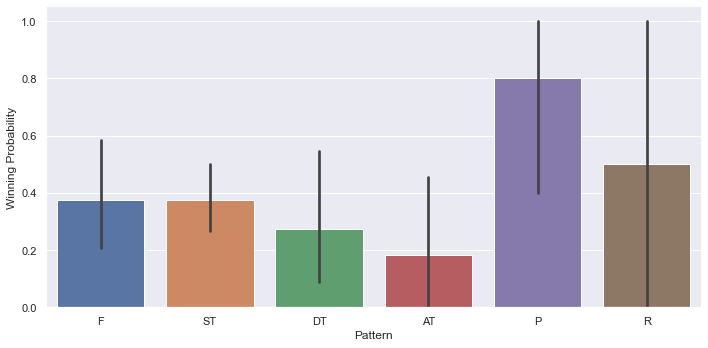

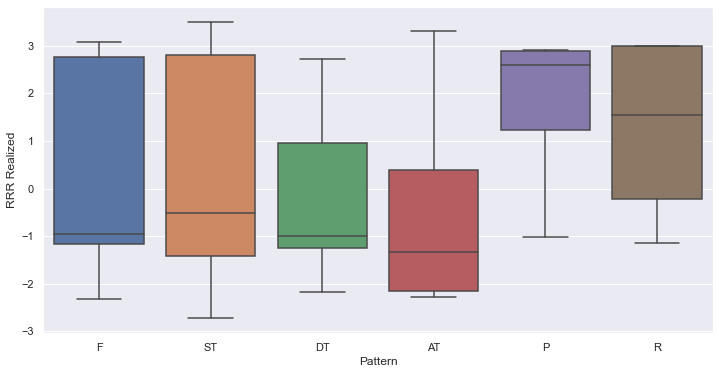

In [91]:


#plot 1
f,axes=plt.subplots(figsize=(12,6))
g1 = sns.countplot(x="Pattern",data=train)



#plot 2
g2= sns.catplot(x="Pattern",y="is_winner",data=train,kind="bar", height = 5,aspect = 2)
g2 = g2.set_ylabels("Winning Probability")
g2 = g2.set_xlabels("Pattern")


#plot 3
f,axes=plt.subplots(figsize=(12,6))
g3 = sns.boxplot(x="Pattern", y="RRR Realized", data=train)




#NOTE: I did not plot the 'R' and 'P' patterns on the third graph due to their low count.

#### Inference:

* 'F' has the most favourable probability which is just above 0.4, the next are 'AT' and 'ST' with about 0.32 and the last is 'DT' with just over 0.2.

* The results for 'R and 'P' cannot be taken seriously due to their low count.

### 5) Float
* 'Float' has many outliers on both sides. For example there are float values below 1 and above 500 in the data, to address the problem I will use log with base 10 to potentially reduce skewness, and to avoid negative values I will simply change the values under 1 to 1 (there aren't many so it won't make much of a difference).
* There are 3 missing values that need to be imputed.

[Text(0, 0.5, 'Float = 10^y')]

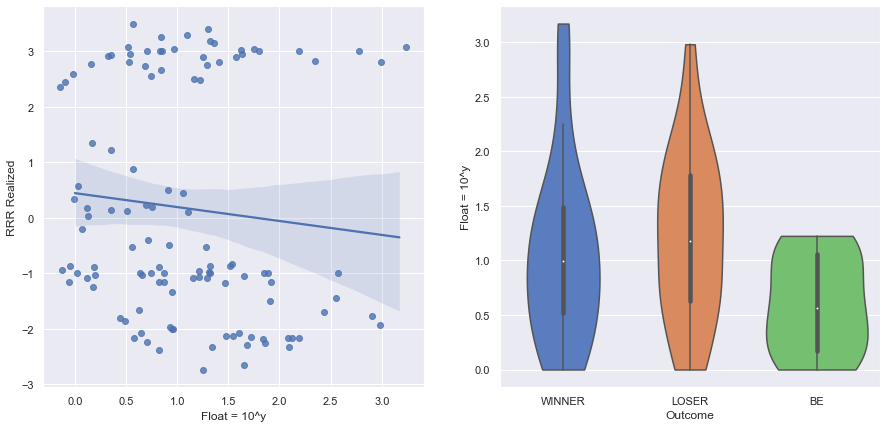

In [92]:


train5 = train.copy()

#change values below 1 to 1
train5['Float'] = train5['Float'].apply(lambda x: 1 if x<1 else x)

# log(x)
train5['Float'] = train5['Float'].apply(lambda x: math.log(x, 10))




fig,ax = plt.subplots(1,2 ,figsize = (15,7))


ax[0] = sns.regplot(x="Float", y="RRR Realized", data=train5,ax = ax[0],x_jitter=.2)

ax[1] = sns.violinplot(x="Outcome", y="Float",data=train5, palette="muted",cut = 0,ax = ax[1])

plt.setp(ax[0], xlabel = "Float = 10^y")
plt.setp(ax[1], ylabel = "Float = 10^y")

40     0.251718
31     0.288672
37     0.471916
56     0.000000
106    0.000000
         ...   
110    0.000000
126    0.000000
21     0.421026
113    0.000000
92     0.000000
Name: Float, Length: 119, dtype: float64

#### Inference: 
It is very difficult to draw conclusions, also here the variance is very high and no bias. Perhaps qualitative variables will perform better. A standard form of distinguishing between floats is: 0-1, 1-8, 8-15, 15-30, 30 -





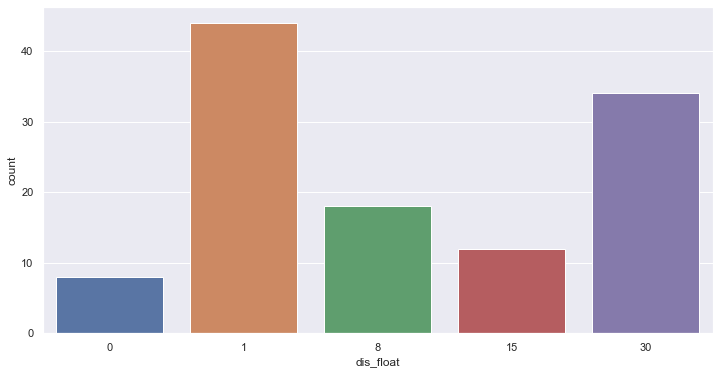

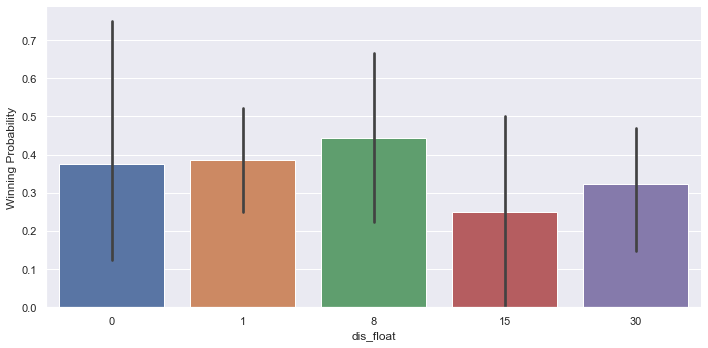

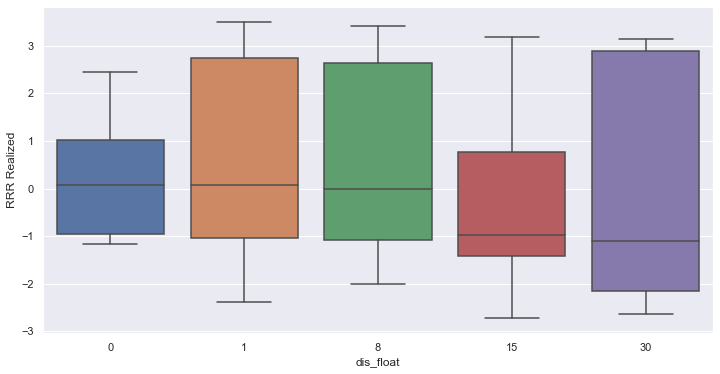

In [94]:
# temporarily drop nulls
train5 = train.copy()
train5 = train5.dropna(subset=['Float'])

def replaceFloat(f):
    if f< 1:
        f = 0
    elif f < 8:
        f = 1
    elif f < 15:
        f = 8
    elif f < 30:
        f = 15
    else:
        f = 30
    return f


train5['dis_float'] = train5['Float'].apply(replaceFloat)


#plot 1
f,axes=plt.subplots(figsize=(12,6))
g1 = sns.countplot(x="dis_float",data=train5)


#plot 2
g2= sns.catplot(x="dis_float",y="is_winner",data=train5,kind="bar", height = 5,aspect = 2)
g2 = g2.set_ylabels("Winning Probability")
g2 = g2.set_xlabels("dis_float")


#plot 3
f,axes=plt.subplots(figsize=(12,6))
g3 = sns.boxplot(x="dis_float", y="RRR Realized", data=train5)


* Floats above 1 and below 15 have a favourable outcome with medians above 0 and winning probability in the 0.35-0.45 range.